In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import math
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from jsonlines import jsonlines
from typing import Dict, List, Any

from src.settings import PREPROCESSED_DIR, MODELS_DIR, LOGS_DIR

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [4]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # return torch.device('cpu')

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled.permute(1, 0, 2, 3) + mask
        scaled = scaled.permute(1, 0, 2, 3)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length)
                          .reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, vocab_size):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x): # batched tokens ids
        x = self.embedding(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        y = (inputs - mean) / std
        out = self.gamma * y + self.beta
        return out

  
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, self_attention_mask):
        residual_x = x.clone()
        x = self.attention(x, mask=self_attention_mask)
        x = self.dropout1(x)
        x = self.norm1(x + residual_x)
        residual_x = x.clone()
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)
        return x
    
class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

class FrameLandmarksEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_frames, d_model, n_landmarks=99):
        super().__init__()
        self.max_sequence_length = max_frames
        self.linear = nn.Linear(n_landmarks, d_model)
        self.position_encoder = PositionalEncoding(d_model, self.max_sequence_length)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):  # seq of frames (landmarks), batched
        # in: (batch_size, n_frames, 99)
        # x = x[:, :self.max_sequence_length, :]
        # x = F.pad(x, (0, 0, 0, self.max_sequence_length - x.size(1)), value=-1)
        x = self.linear(x)
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)
        # out: (batch_size, max_sequence_length, d_model)
        return x

class Encoder(nn.Module):
    def __init__(self, 
                 d_model, 
                 ffn_hidden, 
                 num_heads, 
                 drop_prob, 
                 num_layers,
                 max_sequence_length
                ):
        super().__init__()
        # self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.frames_seq_embedding = FrameLandmarksEmbedding(max_sequence_length, d_model)
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask):
        # x = self.sentence_embedding(x, start_token, end_token)
        x = self.frames_seq_embedding(x)
        x = self.layers(x, self_attention_mask)
        return x


class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size() # in practice, this is the same for both languages...so we can technically combine with normal attention
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask) # We don't need the mask for cross attention, removing in outer function!
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out


class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        _y = y.clone()
        y = self.self_attention(y, mask=self_attention_mask)
        y = self.dropout1(y)
        y = self.layer_norm1(y + _y)

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask)
        y = self.dropout2(y)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y)
        y = self.dropout3(y)
        y = self.layer_norm3(y + _y)
        return y


class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y

class Decoder(nn.Module):
    def __init__(self, 
                 d_model, 
                 ffn_hidden, 
                 num_heads, 
                 drop_prob, 
                 num_layers,
                 max_sequence_length,
                 vocab_size,
                ):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, vocab_size)
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        y = self.sentence_embedding(y)
        y = self.layers(x, y, self_attention_mask, cross_attention_mask)
        return y


class Transformer(nn.Module):
    def __init__(self, 
                d_model, 
                ffn_hidden, 
                num_heads, 
                drop_prob, 
                num_layers,
                max_sequence_length, 
                vocab_size,
                ):
        super().__init__()
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, vocab_size)
        self.linear = nn.Linear(d_model, vocab_size)
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self, 
                x, 
                y, 
                encoder_self_attention_mask=None, 
                decoder_self_attention_mask=None, 
                decoder_cross_attention_mask=None,
    ):
        x = self.encoder(x, encoder_self_attention_mask)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask)
        out = self.linear(out)
        return out

In [5]:
NUM_HEADS = 8
DROP_PROB = 0.1
NUM_LAYERS = 5
D_MODEL = 512
FFN_HIDDEN = 2048

MAX_SEQUENCE_LENGTH = 50  # max in frames = max out tokens
N_LANDMARKS = 99
VOCAB_SIZE = 50_000

BATCH_SIZE = 32
SAMPLE_FRAC = 0.5

In [6]:
class ClipsDataset(Dataset):

    def __init__(self, records: List[Dict[str, Any]], max_input_lenght, max_output_length):
        self.records = records
        self.max_input_lenght = max_input_lenght
        self.max_output_length = max_output_length

    def __len__(self) -> int:
        return len(self.records)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        out_polish_token_ids = torch.tensor(self.records[index]["PolishAnnotationTokenIds"], dtype=torch.int32)
        if len(out_polish_token_ids) > 66:
            # FIXME: this is a hack to make it work with the model; only one clip is affected
            print("Warning: PolishAnnotationTokenIds is longer than 66")
            out_polish_token_ids = out_polish_token_ids[:66]

        out_polish_token_ids = out_polish_token_ids[:self.max_output_length]

        # (seq_len x 33 x 3) -> (seq_len x 99)
        frame_seq_landmarks = torch.tensor(self.records[index]["FramesLandmarksCoords"], dtype=torch.float32).view(-1, 99)
        every_nth_frame_seq_landmarks = frame_seq_landmarks[::4]  # get every 4th frame
        seq_pad_len = self.max_input_lenght - every_nth_frame_seq_landmarks.size(0)
        padded_frame_seq_landmarks = F.pad(every_nth_frame_seq_landmarks, (0, 0, 0, seq_pad_len), value=0)  # 200x99
        # prepro_landmarks_seq = self.preprocess_landmarks_seq(frame_seq_landmarks)

        return {
            "in_landmarks": padded_frame_seq_landmarks,
            "out_polish_token_ids": out_polish_token_ids,
        }

In [7]:
with jsonlines.open(PREPROCESSED_DIR / "clips_dataset_wth_herbert_token_ids.jsonl") as reader:
    # total_records: 19_503
    if SAMPLE_FRAC < 1:
        raw_records = list((rec for rec in reader if np.random.choice([True, False], p=[SAMPLE_FRAC, 1 - SAMPLE_FRAC])))  # iterable approach for random sample
    else:
        raw_records = list(reader)

train_records, val_records = train_test_split(raw_records, test_size=0.2)

In [8]:
train_ds = ClipsDataset(train_records, max_input_lenght=MAX_SEQUENCE_LENGTH, max_output_length=MAX_SEQUENCE_LENGTH)
val_ds = ClipsDataset(val_records, max_input_lenght=MAX_SEQUENCE_LENGTH, max_output_length=MAX_SEQUENCE_LENGTH)

# del train_records, val_records, raw_records

len(train_ds), len(val_ds)

(7813, 1954)

In [9]:
for record in train_ds:
    print(record["in_landmarks"].shape)  # n_frames x n_landmarks*3
    print(record["out_polish_token_ids"].shape)  # padded n_tokens
    break

torch.Size([50, 99])
torch.Size([50])


In [10]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, pin_memory=True)

In [11]:
for record in train_dl:
    print(record["in_landmarks"].shape)  # n_frames x n_landmarks*3
    print(record["out_polish_token_ids"].shape)  # padded n_tokens
    break

torch.Size([32, 50, 99])
torch.Size([32, 50])


In [12]:
EPOCHS = 10
LEARNING_RATE = 1e-4
TOKEN_PROB_THRESHOLD = 0.5

In [13]:
transformer = Transformer(
    d_model=D_MODEL,
    ffn_hidden=FFN_HIDDEN,
    num_heads=NUM_HEADS,
    drop_prob=DROP_PROB,
    num_layers=NUM_LAYERS,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    vocab_size=VOCAB_SIZE,
).to(DEVICE)

In [14]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")

In [15]:
print(f"{tokenizer.pad_token_id=}")
criterion = nn.CrossEntropyLoss(
    ignore_index=tokenizer.pad_token_id,
    reduction="none"
)

# # When computing the loss, we are ignoring cases when the label is the padding token
# for params in transformer.parameters():
#     if params.dim() > 1:
#         nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE)

tokenizer.pad_token_id=1


In [16]:
NEG_INFTY = -1e9

def create_masks(seq_landmarks_batch, token_ids_batch):
    num_sentences = len(seq_landmarks_batch)
    look_ahead_mask = torch.full([MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , False)

    for idx in range(num_sentences):
      seq_landmarks_len, seq_token_ids_len = len(seq_landmarks_batch[idx]), len(token_ids_batch[idx])
      seq_landmarks_pad_mask_ids = np.arange(seq_landmarks_len + 1, MAX_SEQUENCE_LENGTH)
      seq_token_ids_pad_mask_ids = np.arange(seq_token_ids_len + 1, MAX_SEQUENCE_LENGTH)
      encoder_padding_mask[idx, :, seq_landmarks_pad_mask_ids] = True
      encoder_padding_mask[idx, seq_landmarks_pad_mask_ids, :] = True
      decoder_padding_mask_self_attention[idx, :, seq_token_ids_pad_mask_ids] = True
      decoder_padding_mask_self_attention[idx, seq_token_ids_pad_mask_ids, :] = True
      decoder_padding_mask_cross_attention[idx, :, seq_landmarks_pad_mask_ids] = True
      decoder_padding_mask_cross_attention[idx, seq_token_ids_pad_mask_ids, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [17]:
def decode_prediction_batch(pred_batch, tokenizer, threshold=0.3):
    pass

In [18]:
transformer.train()
transformer.to(DEVICE)

metrics_history = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    for batch_num, batch in enumerate(train_dl):
        transformer.train()
        x, y = batch["in_landmarks"].to(DEVICE), batch["out_polish_token_ids"].to(DEVICE)
        # print(f"{x.shape=}, {y.shape=}")

        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(x, y)
        optim.zero_grad()

        prediction = transformer(x, y, encoder_self_attention_mask.to(DEVICE),  decoder_self_attention_mask.to(DEVICE), decoder_cross_attention_mask.to(DEVICE))
        # print(f"{ids_predictions.shape=} {ids_predictions.dtype=}")

        criterion_input = prediction.view(-1, VOCAB_SIZE)
        # print(f"{criterion_input.shape=} {criterion_input.dtype=}")

        criterion_target = y.view(-1).long()
        # print(f"{criterion_target.shape=} {criterion_target.dtype=}")

        loss = criterion(criterion_input, criterion_target)

        valid_indicies = torch.where(criterion_target.view(-1) == tokenizer.pad_token_id, False, True)
        loss = loss.sum() / valid_indicies.sum()
        loss.backward()
        optim.step()

        metrics_history.append({
            "Epoch": epoch + 1,
            "TrainLoss": loss.item(),
        })

        if batch_num % 100 == 0:
            y_batch_decoded = tokenizer.batch_decode(y, skip_special_tokens=True)
            print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")
            ids_predictions = torch.argmax(prediction, dim=-1)
            # thresholded_predictions = torch.where(prediction > TOKEN_PROB_THRESHOLD, 1, 0)
            pred_decoded = tokenizer.batch_decode(ids_predictions, skip_special_tokens=True)
            print(f"Iteration {batch_num} : {loss.item()}")
            print(f"Polish Annotation: {y_batch_decoded[0]}")
            print(f"Prediction: {pred_decoded[0]}")

Epoch 0


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    50000.000000
mean         0.000020
std          0.000012
min          0.000002
25%          0.000011
50%          0.000017
75%          0.000025
max          0.000177
dtype: float64
Iteration 0 : 10.904820442199707
Polish Annotation: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza.
Prediction: duchowe tolerancji pierwoSowizorganizowanie bynajmniej odwiedzin Ośrodkiem przyniosła tendencje ającekspozycji skakskakrezygnują duchowe tendencje Ministrów macieMinistrów Ministrów uciekają Ministrów macienapastJabłonzainteresowała napastaga rezygnują napastnapastnapastŻołnierzy napastdniami dniami dniami uciekają postawił napastdniami Тdniami zabiegał zadownapastMinistrów Ministrów koledzy


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     1.999999e-05
std      4.360072e-03
min      3.986099e-08
25%      2.699204e-07
50%      4.047473e-07
75%      6.122288e-07
max      9.749520e-01
dtype: float64
Iteration 100 : 3.6414968967437744
Polish Annotation: Policjant zastanawia się.
Prediction: Policjant to się. się się się się się się się się się Jak się się się się się się się się się się się się z się się się się


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.428760e-03
min      1.066946e-08
25%      8.542509e-08
50%      1.338538e-07
75%      2.137226e-07
max      9.903109e-01
dtype: float64
Iteration 200 : 2.8657279014587402
Polish Annotation: Kot idzie zadowolony, merda ogonem.
Prediction: Kot idzie i, grui Kot. ósmej grusię uważać się znak Miuje kota uje uważać Migruuje MiJak się się ucieka się się się się się uje się się się się
Epoch 1


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.433808e-03
min      8.429868e-09
25%      7.034219e-08
50%      1.108589e-07
75%      1.803438e-07
max      9.914398e-01
dtype: float64
Iteration 0 : 2.086927652359009
Polish Annotation: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza.
Prediction: Ja myślę, że na przykład nie wolno można wody do kąpieli z n. kota się odkota uje ka Jak MiJak domu się się Jak się Jak Jak Jak Jak Jak z z Jak Jak Jak


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000004e-05
std      4.454079e-03
min      2.419474e-09
25%      2.360693e-08
50%      3.820811e-08
75%      6.578098e-08
max      9.959723e-01
dtype: float64
Iteration 100 : 1.7459313869476318
Polish Annotation: Policjant zastanawia się.
Prediction: Policjant zastanawia się. uje się uje Jak się Jak Jak Jak Jak się się uje się Jak Mimogę Jak uje są uje Jak Jak Jak uje się uje Jeuje się się się Jak Jak uje Jak Jak się Jak Miaby Jak się się mnie


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000004e-05
std      4.456678e-03
min      2.128197e-09
25%      1.769387e-08
50%      2.906483e-08
75%      5.120774e-08
max      9.965535e-01
dtype: float64
Iteration 200 : 1.5681272745132446
Polish Annotation: Kot idzie zadowolony, merda ogonem.
Prediction: Kot idzie zadowolony, do da ogonem. ósmej uważać nich Wtorek ósmej widzi się Wtorek uje ósmej uje ósmej kota ował masz Jak Jak uje uje Jak Wtorek Jak się kota Jak Jak Jak Jak Jak Jak siebie szył Jak blisko Znak raz Jak szył kota
Epoch 2


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000003e-05
std      4.459394e-03
min      1.178548e-09
25%      1.288535e-08
50%      2.162905e-08
75%      3.940991e-08
max      9.971608e-01
dtype: float64
Iteration 0 : 1.3176002502441406
Polish Annotation: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza.
Prediction: Ja myślę, że na przykład nie wolno może wody do kąpieli z kosze. Kiedy luKiedy ósmej pokazuje Jak kierunku mogę ósmej uje Kiedy mogę Jak czy Tak Wtorek ósmej górę się szył Jak górę one Wtorek szył ósmej mogę Kiedy Jak Kiedy Kiedy szył się


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000002e-05
std      4.463116e-03
min      5.439750e-10
25%      6.479788e-09
50%      1.104131e-08
75%      2.062083e-08
max      9.979930e-01
dtype: float64
Iteration 100 : 1.1426523923873901
Polish Annotation: Policjant zastanawia się.
Prediction: Policjant zastanawia się. porządku się widzi górę nich się się Jak szył przechodzi raz się się raz raz raz pokazuje Jak się górę uje się Jak Wtorek się Jak Wtorek szył się Wtorek szył się szył ka Jak Wtorek się się ósmej raz się się chyba się


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.465024e-03
min      3.809544e-10
25%      4.449287e-09
50%      7.633300e-09
75%      1.445527e-08
max      9.984198e-01
dtype: float64
Iteration 200 : 1.0356847047805786
Polish Annotation: Kot idzie zadowolony, merda ogonem.
Prediction: Kot idzie zadowolony, merda ogonem. akwarsię! raz chłopiec uje się się chłopiec się uje dół deszcz k uje uje Kiedy czwartego czwartego czwartego czwartego wszyscy Wtorek Wtorek Wtorek Jak uje Wtorek górę Jak raz Wtorek blisko chłopiec Wtorek Babcia raz raz się
Epoch 3


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000001e-05
std      4.464715e-03
min      4.259833e-10
25%      4.925045e-09
50%      8.417230e-09
75%      1.606995e-08
max      9.983506e-01
dtype: float64
Iteration 0 : 0.9302058815956116
Polish Annotation: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza.
Prediction: Ja myślę, że na przykład nie wolno siódwody do kąpieli z wskaz. raz ósmej szył Jeleń trójraz kota kota uje ósmej ósmej siebie przechodzi przechodzi Wtorek Misię wszyscy się Jak Wtorek chJak szył ował ósmej szył Mimogę szył się się coś


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000001e-05
std      4.467131e-03
min      2.391910e-10
25%      2.911775e-09
50%      5.096888e-09
75%      9.921436e-09
max      9.988908e-01
dtype: float64
Iteration 100 : 0.7791839241981506
Polish Annotation: Policjant zastanawia się.
Prediction: Policjant zastanawia się. lusię raz Miszył deszcz czwartego raz ósmej dą raz siebie się ś szył perkuszył Miósmej pokazuje raz blisko Kiedy się Dziwne się się szył się się Jak Jak Jak się szył Kiedy Kiedy Kiedy Jak Kiedy szył Kiedy Kiedy się


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000001e-05
std      4.467711e-03
min      1.985321e-10
25%      2.187284e-09
50%      3.793054e-09
75%      7.323812e-09
max      9.990206e-01
dtype: float64
Iteration 200 : 0.7319203019142151
Polish Annotation: Kot idzie zadowolony, merda ogonem.
Prediction: Kot idzie zadowolony, merda ogonem. porządku pokazuje kota się ś Dziwne porządku Dziwne wszyscy deszcz raz przechodzi porządku trójDziwne uje przechodzi trójWtorek Wtorek widzi porządku przechodzi się Jak się Jak porządku dą siebie Kiedy chłopiec Wtorek złapał bierze Wtorek przechodzi szył szył
Epoch 4


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000001e-05
std      4.467557e-03
min      2.087583e-10
25%      2.322375e-09
50%      4.061893e-09
75%      8.020419e-09
max      9.989861e-01
dtype: float64
Iteration 0 : 0.6599286198616028
Polish Annotation: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza.
Prediction: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza. kota kota Dziwne Miporządku raz luósmej MiMiKiedy Kiedy się poszli się przechodzi Wtorek przechodzi Wtorek się przechodzi Kiedy Kiedy porządku rynczwartego szył Kiedy szył Znak Kiedy Kiedy przechodzi


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.468023e-03
min      1.396207e-10
25%      1.736843e-09
50%      3.069250e-09
75%      6.095171e-09
max      9.990903e-01
dtype: float64
Iteration 100 : 0.5599091053009033
Polish Annotation: Policjant zastanawia się.
Prediction: Policjant zastanawia się. raz raz się Kiedy Wtorek chszył się deszcz szył raz Miraz trójraz raz wszyscy raz Kiedy Wtorek ty Jak co Wtorek Jak Jak ował się się się chWtorek Wtorek Kiedy Jak Jak szył wiraz raz szył szył szył szył


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000001e-05
std      4.469221e-03
min      7.221546e-11
25%      1.095086e-09
50%      1.963983e-09
75%      3.958307e-09
max      9.993584e-01
dtype: float64
Iteration 200 : 0.5286969542503357
Polish Annotation: Kot idzie zadowolony, merda ogonem.
Prediction: Kot idzie zadowolony, merda ogonem. przechodzi aby trójWtorek ludeszcz u porządku raz widzi Miraz nął czyli czwartego Wtorek Wtorek Wtorek Dlatego czwartego Wtorek położył Wtorek przechodzi Wtorek czwartego Wtorek Kiedy Jak siebie szył Wtorek przechodzi Wtorek wszyscy Kiedy się raz szył
Epoch 5


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000001e-05
std      4.469453e-03
min      8.010069e-11
25%      9.787056e-10
50%      1.766250e-09
75%      3.584312e-09
max      9.994102e-01
dtype: float64
Iteration 0 : 0.4640517830848694
Polish Annotation: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza.
Prediction: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza. Może szył luraz raz raz widzi akwarraz porządku Wtorek deszcz nich deszcz czyli Wtorek porządku Wtorek się chraz się szył przechodzi szył przechodzi przechodzi by się raz szył szył Znak


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.469685e-03
min      4.978369e-11
25%      6.664680e-10
50%      1.207620e-09
75%      2.454997e-09
max      9.994621e-01
dtype: float64
Iteration 100 : 0.40239113569259644
Polish Annotation: Policjant zastanawia się.
Prediction: Policjant zastanawia się. luprzechodzi ósmej się stoją wszyscy raz kierunku raz kierunku coś coś raz ś ś pokazuje ło Kiedy ś Kiedy Kiedy raz luKiedy siebie przechodzi raz wszyscy coś się wszyscy picia Kiedy szył przechodzi chłopiec raz Wtorek ś coś Kiedy szył tyś


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000001e-05
std      4.469542e-03
min      5.870197e-11
25%      6.898426e-10
50%      1.246069e-09
75%      2.561257e-09
max      9.994300e-01
dtype: float64
Iteration 200 : 0.4034537672996521
Polish Annotation: Kot idzie zadowolony, merda ogonem.
Prediction: Kot idzie zadowolony, merda ogonem. porządku trójprzechodzi babci Jeleń trójstoją kierunku Jeleń się porządku Jeleń raz deszcz słoraz przechodzi chłopiec Jeleń coś Wtorek chłopiec szył się chWtorek przechodzi przechodzi przechodzi wszyscy Jeleń raz chłopiec czyli by się się coś się
Epoch 6


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.469955e-03
min      4.520172e-11
25%      7.200695e-10
50%      1.306153e-09
75%      2.706438e-09
max      9.995224e-01
dtype: float64
Iteration 0 : 0.33391934633255005
Polish Annotation: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza.
Prediction: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza. deszcz porządku skreślraz deszcz deszcz porządku porządku nął porządku Kiedy Wtorek stoją deszcz coś Jeleń porządku Wtorek przechodzi przechodzi Obok wieprzechodzi wieWtorek przechodzi przechodzi Kiedy się Kiedy raz Znak szył


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.470340e-03
min      2.348970e-11
25%      3.482010e-10
50%      6.397056e-10
75%      1.338756e-09
max      9.996086e-01
dtype: float64
Iteration 100 : 0.2934947907924652
Polish Annotation: Policjant zastanawia się.
Prediction: Policjant zastanawia się. raz kierunku picia coś stoją chłopiec przechodzi przechodzi ś deszcz ś raz stoją ś im ło ś deszcz położył Kiedy przechodzi zydotyka się ło ucieka Wtorek się szył wszyscy ka zypołożył szył wszyscy szył szył wiszył pływatytał wszyscy ś


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     1.999999e-05
std      4.470154e-03
min      3.012039e-11
25%      3.931726e-10
50%      7.205567e-10
75%      1.505992e-09
max      9.995669e-01
dtype: float64
Iteration 200 : 0.2990601360797882
Polish Annotation: Kot idzie zadowolony, merda ogonem.
Prediction: Kot idzie zadowolony, merda ogonem. się trójś coś kierunku przechodzi raz przechodzi trójwyjeżdżchłopiec szył deszcz Kiedy Kiedy Kuwidzi Dlatego Kiedy Jeleń poszli Kiedy Jeleń dotyka się wszyscy dotyka ś Kiedy szył przechodzi szył Jeleń się się Kiedy raz się się
Epoch 7


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.470370e-03
min      2.447870e-11
25%      3.688721e-10
50%      6.788479e-10
75%      1.429342e-09
max      9.996151e-01
dtype: float64
Iteration 0 : 0.2518574595451355
Polish Annotation: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza.
Prediction: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza. porządku stoją trójdeszcz czyli się dą raz Jeleń dź stoją stoją dź picia dotyka się przechodzi pokazuje chłopiec przechodzi chwszyscy chKiedy Kiedy Wtorek Kiedy przechodzi Babcia pokazuje Jeleń szesnastraz


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000001e-05
std      4.470550e-03
min      2.787447e-11
25%      3.968600e-10
50%      7.300793e-10
75%      1.530864e-09
max      9.996554e-01
dtype: float64
Iteration 100 : 0.2262566238641739
Polish Annotation: Policjant zastanawia się.
Prediction: Policjant zastanawia się. kierunku raz deszcz porządku przechodzi wszyscy ś ś wszyscy ś raz kierunku ś ś ś ś Wtorek raz ś szył raz chłopiec szył dotyka trójdeszcz szył Wtorek porządku Wtorek dotyka dotyka siebie ś raz przechodzi szył szył ławki wszyscy picia ty picia picia


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000002e-05
std      4.470951e-03
min      1.566318e-11
25%      2.201084e-10
50%      4.105764e-10
75%      8.821185e-10
max      9.997451e-01
dtype: float64
Iteration 200 : 0.22238093614578247
Polish Annotation: Kot idzie zadowolony, merda ogonem.
Prediction: Kot idzie zadowolony, merda ogonem. porządku uje kierunku Jeleń Jeleń pali się zaczęli się dem Jeleń Jeleń Jeleń Jeleń przydobry ludotyka ych przechodzi przechodzi fartuował pokazuje się się dotyka wszyscy ś raz Wtorek szył akwarJeleń pomyślał tywieJeleń się
Epoch 8


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.470712e-03
min      1.594151e-11
25%      2.378283e-10
50%      4.412426e-10
75%      9.394853e-10
max      9.996915e-01
dtype: float64
Iteration 0 : 0.17130741477012634
Polish Annotation: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza.
Prediction: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza. dostrzega Kiedy Jeleń raz deszcz pali czwartego deszcz ś pełna przechodzi Kiedy Kiedy skreśldź deszcz się się się chKiedy raz pomyślał ś raz raz Wtorek raz czyli Kiedy raz ś raz


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.470960e-03
min      7.986324e-12
25%      1.471131e-10
50%      2.778889e-10
75%      5.996524e-10
max      9.997471e-01
dtype: float64
Iteration 100 : 0.16027948260307312
Polish Annotation: Policjant zastanawia się.
Prediction: Policjant zastanawia się. uje raz raz typali przechodzi babci raz raz ś aby kierunku prostoś raz ry picia deszcz deszcz coś raz trójchłopiec fartudeszcz przechodzi Jeleń Jeleń kierunku ś chłopiec ty przechodzi Chcę Wtorek szył szył ś przechodzi wszyscy wszyscy wszyscy picia raz


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.471133e-03
min      1.334556e-11
25%      1.867364e-10
50%      3.471229e-10
75%      7.393339e-10
max      9.997858e-01
dtype: float64
Iteration 200 : 0.1570032387971878
Polish Annotation: Kot idzie zadowolony, merda ogonem.
Prediction: Kot idzie zadowolony, merda ogonem. Jeleń wietablestoją dostrzega wieraz stoją Jeleń wiepokazuje Jeleń widzi nić nić ławki liczy wieliczy dą Jeleń Jeleń Jeleń przechodzi ś Wtorek ś ś stoją szybę przechodzi Jeleń ś przechodzi Babcia się Obok raz przechodzi
Epoch 9


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000001e-05
std      4.471011e-03
min      6.815149e-12
25%      1.110941e-10
50%      2.115723e-10
75%      4.675870e-10
max      9.997585e-01
dtype: float64
Iteration 0 : 0.11692168563604355
Polish Annotation: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza.
Prediction: Ja myślę, że na przykład nie wolno nosić wody do kąpieli z morza. przychodzić prostoraz się porządku ych siedemnastraz się pełna siebie dą przechodzi dotyka się się przechodzi ś się się raz przechodzi raz raz Jeleń luJeleń przechodzi raz przechodzi stoją szesnastś


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000000e-05
std      4.471255e-03
min      5.580550e-12
25%      1.202851e-10
50%      2.280922e-10
75%      4.955188e-10
max      9.998129e-01
dtype: float64
Iteration 100 : 0.10740341991186142
Polish Annotation: Policjant zastanawia się.
Prediction: Policjant zastanawia się. kierunku odleluraz wieraz k raz Wtorek uważają mogę deszcz coś ś ś ś pali ś wszyscy pali ś ś ś ś deszcz wszyscy t górę ś ś się Wtorek szkoda deszcz pali szył ś raz Zastanawiam spada biec przechodzi przechodzi ś


/tmp/ipykernel_51506/2702555863.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f"{pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=}")


pd.Series(F.softmax(prediction[0][0]).detach().cpu()).describe()=count    5.000000e+04
mean     2.000001e-05
std      4.471345e-03
min      6.254172e-12
25%      1.111738e-10
50%      2.115845e-10
75%      4.633922e-10
max      9.998331e-01
dtype: float64
Iteration 200 : 0.11461439728736877
Polish Annotation: Kot idzie zadowolony, merda ogonem.
Prediction: Kot idzie zadowolony, merda ogonem. wszyscy wieś Jeleń raz Jeleń ś stoją Jeleń moniJeleń raz dostrzega pali Jeleń Niedziela bagażprzechodzi nić Jeleń bloperkuprzechodzi Jeleń Wtorek tableka picia ś Jeleń Jeleń Jeleń Jeleń Obok ś Obok Wtorek pomyślał szył


In [19]:
metrics_df = pd.DataFrame.from_records(metrics_history)
metrics_df

,Epoch,TrainLoss
0,1,10.904820
1,1,9.461005
2,1,9.158460
3,1,8.537040
4,1,8.279226
...,...,...
2445,10,0.094989
2446,10,0.083586
2447,10,0.076297
2448,10,0.051895


<Axes: xlabel='Epoch', ylabel='TrainLoss'>

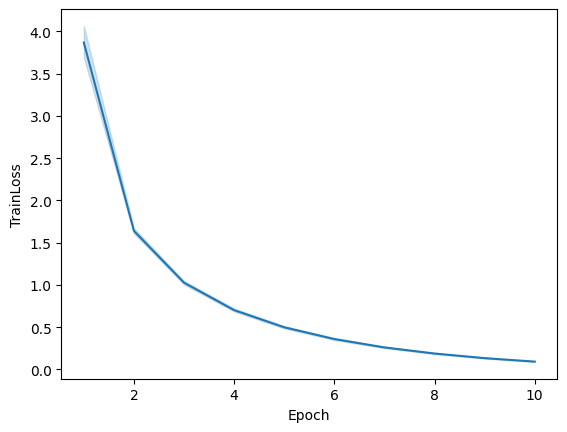

In [20]:
sns.lineplot(data=metrics_df, x="Epoch", y="TrainLoss")

In [21]:
torch.save(transformer.state_dict(), MODELS_DIR / "transformer_v1.pth")

## Playground

In [22]:
encoder = Encoder(
    d_model=D_MODEL,
    ffn_hidden=FFN_HIDDEN,
    num_heads=NUM_HEADS,
    drop_prob=DROP_PROB,
    num_layers=NUM_LAYERS,
    max_sequence_length=MAX_SEQUENCE_LENGTH
).to(DEVICE)

In [23]:
x = torch.randn( (BATCH_SIZE, MAX_SEQUENCE_LENGTH, N_LANDMARKS) ).to(DEVICE) # includes positional encoding
out = encoder(x, self_attention_mask=None)

out.shape

torch.Size([32, 50, 512])

In [24]:
x = torch.randn( (BATCH_SIZE, MAX_SEQUENCE_LENGTH, D_MODEL) ).to(DEVICE)  # seq of frames (landmarks), batched; positional encoded
y = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, MAX_SEQUENCE_LENGTH) ).to(DEVICE)  # batched tokens ids; positional encoded

mask = torch.full([MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH] , float('-inf')).to(DEVICE)
mask = torch.triu(mask, diagonal=1).to(DEVICE)

decoder = Decoder(D_MODEL, FFN_HIDDEN, NUM_HEADS, DROP_PROB, NUM_LAYERS, MAX_SEQUENCE_LENGTH, VOCAB_SIZE).to(DEVICE)

out = decoder(x, y, mask, mask)

In [25]:
out.shape

torch.Size([32, 50, 512])

In [26]:
transformer = Transformer(
    d_model=D_MODEL,
    ffn_hidden=FFN_HIDDEN,
    num_heads=NUM_HEADS,
    drop_prob=DROP_PROB,
    num_layers=NUM_LAYERS,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    vocab_size=VOCAB_SIZE,
).to(DEVICE)

In [27]:
x = torch.randn( (BATCH_SIZE, MAX_SEQUENCE_LENGTH, N_LANDMARKS) ).to(get_device())
y = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, MAX_SEQUENCE_LENGTH) ).to(get_device())

result = transformer(x, y)

In [28]:
result.shape

torch.Size([32, 50, 50000])

In [29]:
result

tensor([[[ 0.9627,  0.0483, -0.8679,  ...,  0.1195, -0.1094,  0.6290],
         [ 0.9919,  0.0301, -0.3626,  ...,  0.4176, -0.1630,  0.6565],
         [ 0.7686, -0.1704,  0.1748,  ...,  0.5258, -1.4025,  0.5030],
         ...,
         [ 0.7538,  0.4849, -0.0271,  ...,  0.6694, -0.9478,  0.5285],
         [ 1.4585, -0.0435,  0.2559,  ...,  0.3148, -0.3352,  0.6046],
         [ 1.2859, -0.6242, -0.3211,  ...,  0.3898, -0.2568,  0.9221]],

        [[ 0.3515, -0.5566,  0.1684,  ...,  0.4672, -0.3015,  0.6946],
         [ 0.2413,  0.2286,  0.3218,  ...,  0.4733, -0.5607,  0.3345],
         [-0.6346,  0.3005,  0.4521,  ...,  0.2904, -0.2683, -0.0039],
         ...,
         [ 1.1504,  0.6891,  0.5858,  ...,  0.1815, -0.2292,  1.2092],
         [ 0.3794,  0.1834,  1.0685,  ..., -0.5546, -0.6466,  0.8908],
         [ 0.7399, -0.4228,  0.7433,  ..., -0.5248, -0.4261,  0.9464]],

        [[ 0.2302, -0.3049,  0.0202,  ..., -0.2127, -0.0866,  0.4929],
         [ 0.9873, -0.2797, -0.7383,  ...,  0